# Midterm
#### Rahul Birmiwal
#### DATA 558 
#### Professor Harchoui

## Function/Class Source Code

In [105]:


class LinearSVM_SquaredLoss_NEW():
        def __init__(self,lamb=0.1):
            self.betaCoef = None
            self.X_train = None
            self.y_train = None
            self.N = 0
            self.D = 0
            self.lamb = lamb
            self.betas = []
            self.currNonZeroIndices = None


        def obj(self, beta):
            """Return scalar value of the objective function for a given beta"""

            X,y,lamb,b = self.X_train.copy(), self.y_train.copy(), self.lamb, beta.copy()
            J = 0.0
            for i in np.arange(0,self.N):
                row = X[:,i]
                J += (np.maximum(0, 1- y[i]*row.T.dot(b)))
            J *= 1 / self.N
            J += lamb*np.linalg.norm(b)**2
            return J
        def get_batch(self, batch_size=1024):
            X=self.X_train.T
            y=self.y_train
            random_idxs = np.random.choice(len(y), len(y), replace=False)

            X_shuffled = X[random_idxs,:]
            y_shuffled = y[random_idxs]
            mini_batches = [(X_shuffled[i:i+batch_size,:], y_shuffled[i:i+batch_size]) for
                           i in range(0, len(y), batch_size)]
            return mini_batches
        def grad(self, beta):
            X,y,lamb,b = self.X_train.copy(), self.y_train.copy(), self.lamb, beta.copy()
            J = 0.0
            for i in np.arange(0,self.N):
                row = (X[:,i])
                #print(b.shape)
                J += -2.0*(np.maximum(0, 1- y[i]*row.T.dot(b)))*y[i]*X.T[i]
            J *= 1 / self.N
            J += 2*lamb*b
            return J
        def computegrad_wrt_batch(self,beta,batch ):
            """
            returns the gradient of obj() defined above for a given beta and lambda
            """
            lamb = self.lamb
            X = batch[0].T
            y = batch[1]
            b = beta
            J = 0.0
            
            for i in np.arange(0,len(y)):
                row = (X[:,i])
                #print(b.shape)
                J += -2.0*(np.maximum(0, 1- y[i]*row.T.dot(b)))*y[i]*X.T[i]
            J *= 1 / self.N
            J += 2*lamb*b
            return J

        def bt_line_search(self,x, t, alpha=0.5, beta=0.9, max_iter=1000):
            #return 0.0001
            """
            Perform backtracking line search
            Inputs:
              - x: Current point
              - t: Starting (maximum) step size
              - alpha: Constant used to define sufficient decrease condition
              - beta: Fraction by which we decrease t if the previous t doesn't work
              - max_iter: Maximum number of iterations to run the algorithm
            Output:
              - t: Step size to use
            """
            lamb = self.lamb
            grad_x = self.grad(x)  # Gradient at x
            norm_grad_x = np.linalg.norm(grad_x)  # Norm of the gradient at x
            found_t = False
            epsilon = 0.001
            i = 0  # Iteration counter
            while (found_t is False and i < max_iter):
                # INSERT THE SUFFICIENT DECREASE CONDITION FOR BACKTRACKING LINE SEARCH IN THE
                # if STATEMENT BELOW.
                #print(i)
                term_A = self.obj(x - t*grad_x)
                term_B = self.obj(x) - alpha*t*norm_grad_x**2
                cond = term_A - epsilon < term_B
                #print(term_A, " ", term_B)
                if cond:
                    found_t = True
                elif i == max_iter - 1:
                    raise('Maximum number of iterations of backtracking reached')
                else:
                    # INSERT THE UPDATE TO t HERE
                    t *= beta
                    i += 1
            return t
        def stochastic_gd(self,t_init, max_iter,epsilon=0.0001):
            lamb = self.lamb
            beta_init = np.zeros(self.D)
            theta_init = np.zeros(self.D)
            b = beta_init
            #theta = theta_init

            #grad_theta = self.computegrad(theta)
            grad_beta = self.grad(b)
            self.betas = [b]
            t = t_init
            
            batches_per_iter = 2

            iter = 0
            velocity = 0 #initial velocity
            while iter < max_iter and np.linalg.norm(grad_beta) > epsilon:
                if (iter%50==0):
                    print(iter, " ", np.linalg.norm(grad_beta))

                shuffledBatches = self.get_batch()
                for batch in shuffledBatches[0 : batches_per_iter-1]:
                    grad_beta = self.computegrad_wrt_batch(b,batch)
                    """Momentum Step"""
                    if (iter < 100):
                        gamma = 0.5
                    else:
                        gamma = 0.9
                    velocity = gamma*velocity + t*grad_beta
                    b = b - velocity

                grad_beta = self.computegrad_wrt_batch(b,batch)
                iter += 1
                self.betas.append(b)
            self.betaCoef =  np.array(self.betas[-1])
        def mylinearsvm(self,t_init, max_iter):

            lamb = self.lamb
            beta_init = np.zeros(self.D)
            theta_init = np.zeros(self.D)

            b = beta_init
            theta = theta_init

            grad_theta = self.grad(theta)
            grad_beta = self.grad(b)

            self.betas = [b]
            t = t_init
            iter = 0
            while iter < max_iter:

                #compute eta via backtracking
                t = self.bt_line_search(b, t,lamb)

                #print(iter, " ", np.linalg.norm(grad_beta))

                #updates to beta/theta
                prior_b = b
                b = theta - t*grad_theta
                theta = b + (iter/(iter+3))*(b-prior_b)

                grad_theta = self.grad(theta)
                grad_beta = self.grad(b)
                iter += 1
                self.betas.append(b)

            self.betaCoef =  np.array(self.betas[-1])



        def fit(self, X_train,y_train, method,t_init = 2/IMAGENET_MAX_EIGENVALUE, max_iter = 1000):
            """Fit _this_ classifier to training data. Also provide step size and maximum
               number of iterations for gradient descent

               Arguments:
                   -X_train (dataframe d x n )
                   -y_train (nx1 numpy array )
                   - t_init (float): initial step size for gradient descent. Default is the lipschitz Constant
                         i.e. the 2 / maxeigenvalue of (X^TX + LambdaId)
                   -max_iter (int): maximum number of iterations
            """
            self.X_train=X_train
            self.y_train = y_train
            self.N,self.D = X_train.shape[1],X_train.shape[0]
            if (method == 'fastgradalgo'):
                self.mylinearsvm(t_init, max_iter)
            elif (method == 'SGD'):
                self.stochastic_gd(t_init,max_iter)
            else:
                pass
        def score(self, X_test,y_test):
            predictions = hypothesis(X_test, self.betaCoef)
            return np.mean(y_test==predictions)

def hypothesis(X, beta):
    return np.sign(np.matmul(X.T, beta))
def misclassification_error(X,y_actual,beta_iterates):

    predictions = [hypothesis(X,beta_iterates[k]) for k in range(0,len(beta_iterates))]
    errs = [(1 - np.mean(predictions[k]==y_actual) ) for k in range(0,len(predictions))]
    return errs
def my_cross_validation(X, y,iters,N_SPLITS=3 ):

    kf = KFold(n_splits=N_SPLITS)
    sum = 0
    t_init = 0.001

    lambs = np.logspace(-4,4,num=20)
    best_lamb = 0
    best_score=-9999
    for lam in lambs:
        sum_score = 0.0
        print("...Running classifier with lambda={}".format(lam))
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            classifier = LinearSVM_SquaredLoss_NEW(lam)

            #ensuring transposed input
            classifier.fit(X_train.T,y_train,'SGD', t_init, iters)
            score = classifier.score(X_test.T, y_test)
            sum_score += score
        avg_score = sum_score / N_SPLITS
        print("Lambda {} had accuracy score of {}".format(lam, avg_score))
        if (avg_score > best_score):
            best_score = avg_score
            best_lamb = lam
    return best_lamb


def fit(bird1 = 'toucan', bird2 = 'hornbill'):
    (X_train,y_train,X_test,y_test) = load_bird_data(bird1, bird2)
    t_init = 2/IMAGENET_MAX_EIGENVALUE
    t_init = 1.0
    lamb = 1.0
    max_iter = 1000

    svm_clf = LinearSVM_SquaredLoss_NEW(lamb)
    svm_clf.fit(X_train.T,y_train,t_init,max_iter)
    beta_iterates = svm_clf.betas
    np.savetxt('betaIterates_' + bird1+bird2+'_SGD.csv', beta_iterates, delimiter=" ", fmt='%.9f')

def classify(setName, beta_file_path):
    (X_train,y_train,X_test,y_test) = load_bird_data('toucan', 'hornbill')
    beta_iterates = np.genfromtxt(beta_file_path, delimiter= " ")
    if (setName == 'Training'):
        errs = misclassification_error(X_train.T, y_train, beta_iterates)
    else:
        errs = misclassification_error(X_test.T, y_test, beta_iterates)
    print(errs)

def cross_validation_tuning():
    iters = 200
    (X_train,y_train,X_test,y_test) = load_bird_data('hornbill', 'toucan')

    optimal_lamb = my_cross_validation(X_train,y_train,iters)
    print("optimal lambda found is {}".format(optimal_lamb))


## Problem 1 

In [291]:
"""Load spam training data """

spamData = pd.read_csv('spam.csv', sep=' ', header=0)

y_train = spamData.iloc[:,-1]
y_train = np.where(y_train==0,-1,1) #ensure -1/1 labeling for svm 

X_train=  spamData.iloc[:, :-1]

# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
print(X_train.shape, y_train.shape)

(4600, 57) (4600,)



Train your linear support vector machine with the squared hinge loss on the the Spam dataset for the λ = 1. Report your misclassification error for this value of λ.

In [296]:
"""Compute the maximum eigenvalue of X^TX + LambdaI for Lipschitz Constant"""
lamb = 1.0
max_eig = max_eigenvalue(X_train.shape[0],lamb, X_train,y_train)
print("Maximum eigenvalue for the spam dataset is:{}".format(max_eig))
L_constant = 2/max_eig
print("Initial Eta for Gradient Descent will therefore be: {}".format(L_constant))

"""Fit classifer"""
svm_clf = LinearSVM_SquaredLoss_NEW(lamb)
svm_clf.fit(X_train.T, y_train, L_constant, 1000)

Maximum eigenvalue for the spam dataset is:8.591888493239582
Initial Eta for Gradient Descent will therefore be: 0.2327776950985426


In [301]:
final_beta = svm_clf.betaCoef
np.savetxt('MT_p1-4_finalbeta.csv',final_beta,delimiter=" ")

beta_iterates = svm_clf.betas
np.savetxt('MT_p1-4_betaIterates.csv',beta_iterates,delimiter=" ")



In [307]:
"""Misclassification Error on Training Set"""

err = 1 - svm_clf.score(X_train.T,y_train)
print("Misclassification error on training set with Lambda=1.0 is ", err)

0.9104347826086957

Find the optimal value of λ using 5-fold cross-validation, and boost iterations back to 1000 here. Report your misclassification error for that value of λ.

In [313]:
iters=1000
optimal_lamb = my_cross_validation(X_train,y_train,iters,
                                   N_SPLITS=5, lambdaParams = np.arange(1,100,10))
print("optimal lambda found is {}".format(optimal_lamb))

...Running classifier with lambda=1
Lambda 1 had accuracy score of 0.8652198355007735
...Running classifier with lambda=11
Lambda 11 had accuracy score of 0.8789079764236486
...Running classifier with lambda=21


KeyboardInterrupt: 

Seems the optimal value for lambda is 50. It has misclassification error of 1.0 - 0.8782 ~= 12.18% We can now 'zoom in' on this region now and rerun cross validation using 5-fold cross validation: 

## PROBLEM 2

Pick two classes of your choice from the dataset. Train a classifier using a linear support vector machine with the squared hinge loss on the training set using your own fast gradient algorithm with λ = 1. Be sure to use the features you generated in the homeworks rather than the raw image features. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.

This problem was done on AWS. In the above code, in function fit() will run extract_features.py on folders containing hornbill and toucan images respectively and standardize this data into resultant x_train, y_train, etc. sets. The SVM was fitted to this training data and the beta iterates from fast gradient descent were saved to a csv file (attached to this submission folder). We load that here and use that to plot misclassification error. 



In [61]:
x_train = np.genfromtxt('X_train_hornbilltoucan.csv', delimiter = " ")
y_train = np.genfromtxt('y_train_hornbilltoucan.csv', delimiter = " ")
x_test = np.genfromtxt('X_test_hornbilltoucan.csv', delimiter = " ")
y_test = np.genfromtxt('y_test_hornbilltoucan.csv', delimiter = " ")



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



### TESTING Classifier: Fast Gradient Method vs. Stochastic Gradient Descent

In [88]:
t_init = 0.001
lamb = 1.0
max_iter=1000

clf = LinearSVM_SquaredLoss_NEW(lamb)
clf.fit(x_train.T, y_train, 'SGD',t_init, max_iter)

0   10.407290630002372
50   0.9266402820116326
100   0.4487171333889922
150   0.03532086473793412
200   0.0050150467851801045
250   0.001133881434601202
300   0.00029268796375934834


### TESTING Continued...Misclassification Error Tests

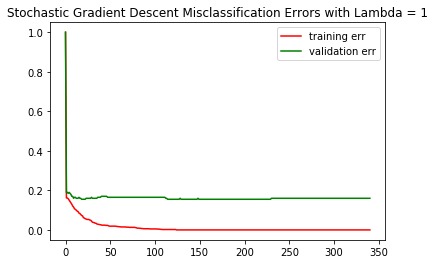

In [89]:
betaIterates = clf.betas

training_data_errs = misclassification_error(x_train.T, y_train, betaIterates)
validation_data_errs = misclassification_error(x_test.T, y_test, betaIterates)
from matplotlib import pyplot as plt

plt.plot(training_data_errs, 'r',label='training err')
plt.plot(validation_data_errs, 'g',label='validation err')
plt.legend()
plt.title('Stochastic Gradient Descent Misclassification Errors with Lambda = 1')
plt.show()

Now let's retrieve the beta iterates obtained using the fast gradient method, and compare errors of the two methods (SGD,FGD) as functions of iterations. _Note_: We zoom in on the bottom-left region to get a better picture

In [93]:

betaIterates = np.genfromtxt('betaIterates_ToucanHornbill.csv', delimiter = " ")


training_data_errs_fgd = misclassification_error(x_train.T, y_train, betaIterates)
validation_data_errs_fgd = misclassification_error(x_test.T, y_test, betaIterates)


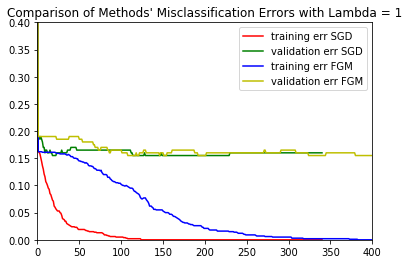

In [102]:
plt.plot(training_data_errs, 'r',label='training err SGD')
plt.plot(validation_data_errs, 'g',label='validation err SGD')
plt.plot(training_data_errs_fgd, 'b',label='training err FGM')
plt.plot(validation_data_errs_fgd, 'y',label='validation err FGM')
plt.legend()
plt.xlim(0,400)
plt.ylim(0,0.4)
plt.title('Comparison of Methods\' Misclassification Errors with Lambda = 1')
plt.show()

Find the value of the regularization parameter λ using 3-fold cross-validation; write your own function for this purpose. Train a classifier using a linear support vector machine with the squared hinge loss on the training set using your own fast gradient algorithm with that value of λ found by 3-fold cross-validation. Plot, with different colors, the misclassification error on the training set and on the test set vs iterations.

We use the my_cross_validation function above. This was run on AWS. The output text, showing lambda-score pairs is shown below this function code. 

In [106]:
best_lamb = my_cross_validation(x_train,y_train,250,3)

...Running classifier with lambda=0.0001
0   10.62131782952719
50   1.1263283586834099
100   0.6047119994641555
150   0.06482776151511563
200   0.010779092324122231
0   11.275084664410148
50   1.0715666444396517
100   0.5530030950066427
150   0.0665223329671499
200   0.01024154604103865
0   10.134550971156465
50   1.1041316141674804
100   0.5765252855844158
150   0.07300427436545111
200   0.014672163804645335
Lambda 0.0001 had accuracy score of 0.8149736562910216
...Running classifier with lambda=0.00026366508987303583
0   10.62131782952719
50   1.1262870994943035


KeyboardInterrupt: 

## Problem 2 Redux: Different Birds

For the sake of completeness we will run the above set of anaylses on a different bird pair -- say 'lorikeet' and 'red-breasted'merganser'. Data was obtained using load_bird_data() like before, stored as csv files from AWS, and stored in this containing submission folder too

In [55]:
betaIterates = np.genfromtxt('betaIterates_MerganserLorikeet.csv', delimiter = " ")

x_train = np.genfromtxt('X_train_merganserLorikeet.csv', delimiter = " ")
y_train = np.genfromtxt('y_train_merganserLorikeet.csv', delimiter = " ")
x_test = np.genfromtxt('X_test_merganserLorikeet.csv', delimiter = " ")
y_test = np.genfromtxt('y_test_merganserLorikeet.csv', delimiter = " ")



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)



training_data_errs = misclassification_error(x_train.T, y_train, betaIterates)
validation_data_errs = misclassification_error(x_test.T, y_test, betaIterates)
print("Showing first 50 error iterates of training data....")
training_data_errs[0:50]

Showing first 50 error iterates of training data....


[1.0,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.008000000000000007,
 0.00

In [54]:
b=betaIterates[-1]
b.shape
x_test.dot(b)

ValueError: shapes (819200,1) and (4096,) not aligned: 1 (dim 1) != 4096 (dim 0)

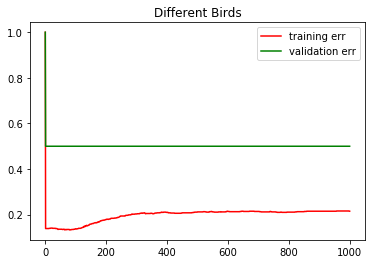

In [41]:

plt.plot(training_data_errs, 'r',label='training err')
plt.plot(validation_data_errs, 'g',label='validation err')
plt.legend()
plt.title('Different Birds')
plt.show()

* Um...still same problem with validation set error...? If we zoo